In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression  # Or any other final estimator

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import xgboost as xgb

In [2]:
# Read in the data
data_path = '../../preprocessing/data'

# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet')
# Columns in A but not in test_A



A = pd.concat([obs_A, est_A]).drop(columns=['date_forecast'])
B = pd.concat([obs_B, est_B]).drop(columns=['date_forecast'])
C = pd.concat([obs_C, est_C]).drop(columns=['date_forecast'])

A.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in A.columns]
test_A.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in test_A.columns]
B.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in B.columns]
test_B.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in test_B.columns]
C.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in C.columns]
test_C.columns = ["".join(char for char in col if char not in set('{}:,<&>@`')) for col in test_C.columns]


In [3]:
X_A = A.drop(columns=['pv_measurement'])
y_A = A['pv_measurement']

X_B = B.drop(columns=['pv_measurement'])
y_B = B['pv_measurement']

X_C = C.drop(columns=['pv_measurement'])
y_C = C['pv_measurement']


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor


# Assuming X_A and y_A are defined and imported as required

X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.5, shuffle=True, random_state=42)


# Create and configure a CatBoost model instance with provided parameters
model_catboost = CatBoostRegressor(
    subsample=0.99,
    rsm=0.9,
    random_strength=0.3,
    min_data_in_leaf=20,
    learning_rate=0.09,
    l2_leaf_reg=6,
    grow_policy='SymmetricTree',
    iterations=700,
    depth=10,
    border_count=17,
    bootstrap_type='Bernoulli',
    early_stopping_rounds=23,
    sampling_frequency='PerTreeLevel'
)


# Best parameters for XGBoost
best_params_xgboost = {
    'n_estimators': 500,
    'learning_rate': 0.01,
    'max_depth': 8,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'gamma': 0.2,
    'min_child_weight': 5,
    'reg_alpha': 0,
    'reg_lambda': 1.5,
    'booster': 'gbtree',
    'random_state': 0
}

# Create and fit an XGBoost model instance
model_xgboost = xgb.XGBRegressor(**best_params_xgboost)

# Corrected best parameters for LightGBM
best_params_lightgbm = {
    'num_leaves': 31, 
    'learning_rate': 0.02, 
    'n_estimators': 500, 
    'max_depth': 14, 
    'reg_lambda': 3, 
    'objective': 'regression', 
    'metric': 'mae', 
    'random_state': 42
}

# Create and fit a LightGBM model instance
model_lightgbm = lgb.LGBMRegressor(**best_params_lightgbm)

# SVM Regressor and pipeline (commented out if not used)
# svm_regressor = SVR(C=1.0, epsilon=0.1, kernel='rbf')
# svm_pipeline = make_pipeline(StandardScaler(), svm_regressor)

ridge_regressor = Ridge(alpha=1.0)  

# List of estimators for stacking
estimators = [
    ('xgboost', model_xgboost),
    # ('lightgbm', model_lightgbm),
    # ('ridge', ridge_regressor)
    ('catboost', model_catboost)
    # ('svm', svm_pipeline) # Uncomment if SVM is to be included
]

# Create the StackingRegressor
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(), 
    cv=5
)

# Fit the StackingRegressor
model_A = stacking_regressor.fit(X_train_A, y_train_A)




0:	learn: 1080.4678877	total: 66ms	remaining: 46.1s
1:	learn: 1006.3759043	total: 74.8ms	remaining: 26.1s
2:	learn: 938.5785786	total: 83.5ms	remaining: 19.4s
3:	learn: 878.8749523	total: 92.3ms	remaining: 16.1s
4:	learn: 825.5457409	total: 101ms	remaining: 14.1s
5:	learn: 776.0852340	total: 111ms	remaining: 12.9s
6:	learn: 732.7321526	total: 122ms	remaining: 12.1s
7:	learn: 694.3905956	total: 131ms	remaining: 11.3s
8:	learn: 661.9252362	total: 143ms	remaining: 11s
9:	learn: 632.4454357	total: 154ms	remaining: 10.6s
10:	learn: 604.1068675	total: 164ms	remaining: 10.3s
11:	learn: 579.6255242	total: 174ms	remaining: 9.96s
12:	learn: 559.2630561	total: 186ms	remaining: 9.84s
13:	learn: 539.7027523	total: 193ms	remaining: 9.48s
14:	learn: 522.9995107	total: 205ms	remaining: 9.37s
15:	learn: 508.2254237	total: 213ms	remaining: 9.1s
16:	learn: 495.7826810	total: 224ms	remaining: 9s
17:	learn: 484.4925779	total: 232ms	remaining: 8.79s
18:	learn: 474.5612602	total: 242ms	remaining: 8.68s
19:	l

MAE: 175.68010152711193


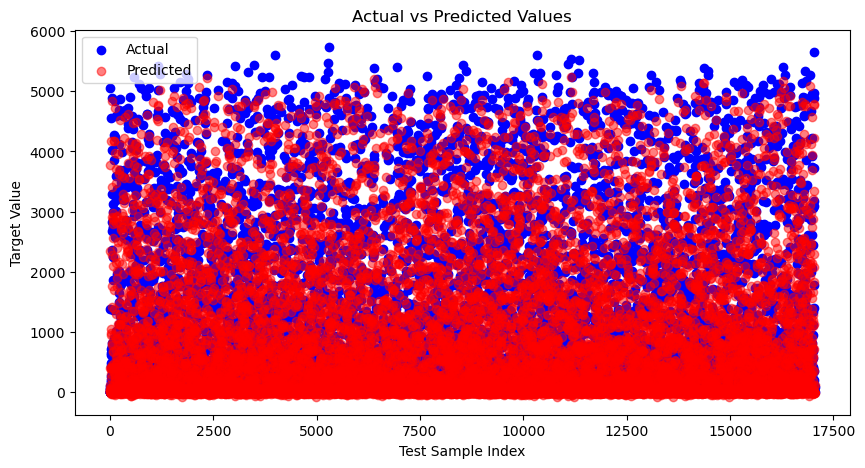

In [5]:
y_pred_A_test = model_A.predict(X_test_A)

# Calculate the mse
mse = mean_absolute_error(y_test_A, y_pred_A_test)
print(f'MAE: {mse}')

# Plotting the actual vs predicted values
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_A)), y_test_A, color='blue', label='Actual')
plt.scatter(range(len(y_pred_A_test)), y_pred_A_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()

In [6]:
#Split data for B

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, shuffle=True, random_state=42)

# stacking_regressor.fit(X_B, y_B)
model_B = stacking_regressor.fit(X_B, y_B)


0:	learn: 181.1960916	total: 24.9ms	remaining: 17.4s
1:	learn: 168.9948759	total: 49.4ms	remaining: 17.2s
2:	learn: 158.6283373	total: 71.4ms	remaining: 16.6s
3:	learn: 148.9178898	total: 89.6ms	remaining: 15.6s
4:	learn: 140.3091253	total: 111ms	remaining: 15.5s
5:	learn: 132.5014289	total: 135ms	remaining: 15.6s
6:	learn: 125.3773022	total: 157ms	remaining: 15.6s
7:	learn: 119.4324391	total: 177ms	remaining: 15.3s
8:	learn: 113.5762446	total: 194ms	remaining: 14.9s
9:	learn: 108.1009747	total: 210ms	remaining: 14.5s
10:	learn: 103.4349068	total: 230ms	remaining: 14.4s
11:	learn: 99.5539811	total: 247ms	remaining: 14.2s
12:	learn: 96.0247230	total: 265ms	remaining: 14s
13:	learn: 92.7706869	total: 284ms	remaining: 13.9s
14:	learn: 90.0495728	total: 301ms	remaining: 13.7s
15:	learn: 87.4146337	total: 324ms	remaining: 13.8s
16:	learn: 85.0516114	total: 345ms	remaining: 13.9s
17:	learn: 82.8306607	total: 362ms	remaining: 13.7s
18:	learn: 81.0359612	total: 380ms	remaining: 13.6s
19:	learn

MAE: 26.44387859290565


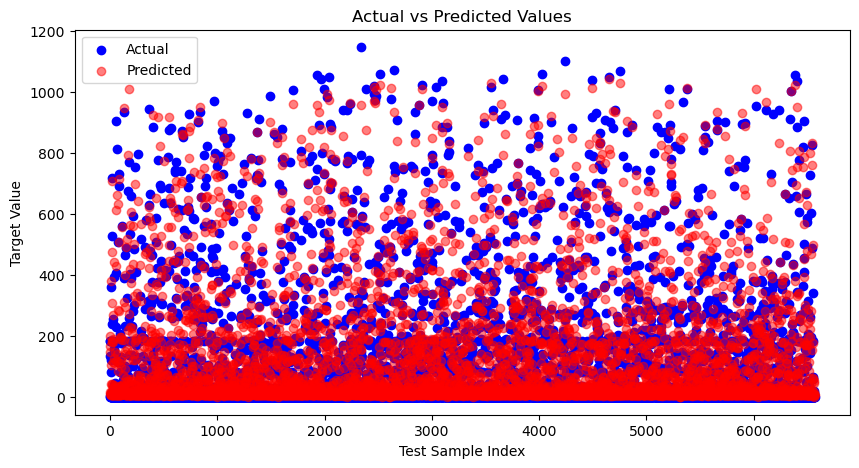

In [7]:
# Predict the labels of the test set: y_pred

y_pred_B_test = model_B.predict(X_test_B)

# Calculate the mse
mse = mean_absolute_error(y_test_B, y_pred_B_test)
print(f'MAE: {mse}')

# Plotting the actual vs predicted values
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_B)), y_test_B, color='blue', label='Actual')
plt.scatter(range(len(y_pred_B_test)), y_pred_B_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [8]:
# Split data for C

X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2, shuffle=True, random_state=42)

# stacking_regressor.fit(X_C, y_C)
model_C = stacking_regressor.fit(X_C, y_C)



0:	learn: 153.3740466	total: 12.8ms	remaining: 8.97s
1:	learn: 142.1866805	total: 29.1ms	remaining: 10.2s
2:	learn: 131.9907822	total: 41.3ms	remaining: 9.59s
3:	learn: 122.7846078	total: 53.7ms	remaining: 9.35s
4:	learn: 114.7739732	total: 66ms	remaining: 9.17s
5:	learn: 107.5756242	total: 77.6ms	remaining: 8.97s
6:	learn: 101.1188252	total: 89.8ms	remaining: 8.89s
7:	learn: 95.3889205	total: 106ms	remaining: 9.19s
8:	learn: 90.1349617	total: 121ms	remaining: 9.26s
9:	learn: 85.3933465	total: 138ms	remaining: 9.51s
10:	learn: 81.2153541	total: 154ms	remaining: 9.66s
11:	learn: 77.6015025	total: 176ms	remaining: 10.1s
12:	learn: 74.3306857	total: 191ms	remaining: 10.1s
13:	learn: 71.4242686	total: 207ms	remaining: 10.1s
14:	learn: 68.7795254	total: 225ms	remaining: 10.3s
15:	learn: 66.5058764	total: 248ms	remaining: 10.6s
16:	learn: 64.5249407	total: 262ms	remaining: 10.5s
17:	learn: 62.7958616	total: 275ms	remaining: 10.4s
18:	learn: 61.2669866	total: 293ms	remaining: 10.5s
19:	learn:

MAE: 9.866817089955243


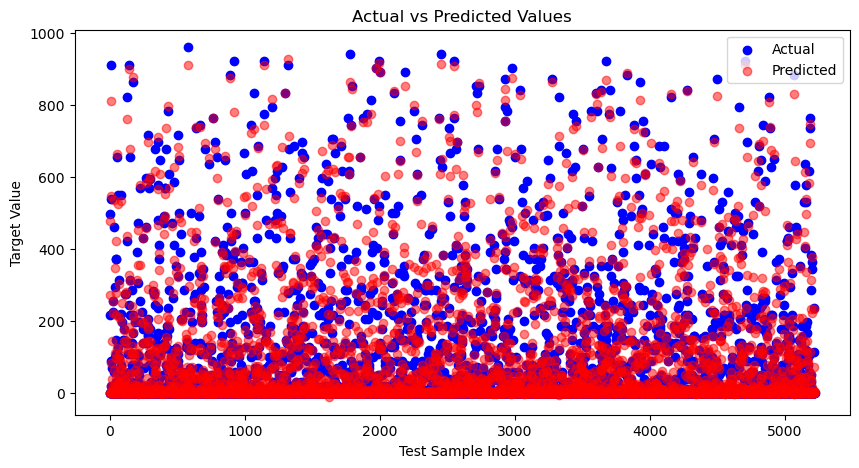

In [9]:
# Predict the labels of the test set: y_pred

y_pred_C_test = model_C.predict(X_test_C)

# Calculate the mse
mse = mean_absolute_error(y_test_C, y_pred_C_test)
print(f'MAE: {mse}')

# Plotting the actual vs predicted values
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_C)), y_test_C, color='blue', label='Actual')
plt.scatter(range(len(y_pred_C_test)), y_pred_C_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [10]:
def create_submission(pred_A, pred_B, pred_C, output_file="submission.csv"):
    """
    Create a Kaggle submission file.

    Parameters:
    - pred_A, pred_B, pred_C: Arrays containing predictions.
    - output_file: Name of the output CSV file.

    Returns:
    - None. Writes the submission to a CSV file.
    """
    
    # Concatenate predictions
    predictions = np.concatenate([pred_A, pred_B, pred_C])

    # Create an id array
    ids = np.arange(0, len(predictions))

    # Create a DataFrame
    df = pd.DataFrame({
        'id': ids,
        'prediction': predictions
    })

    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")

pred_A = model_A.predict(test_A)
pred_B = model_B.predict(test_B)
pred_C = model_C.predict(test_C)

create_submission(pred_A, pred_B, pred_C, output_file="../../catty_boosty_submission.csv")

ValueError: Feature shape mismatch, expected: 54, got 55